In [1]:
import json
import csv
import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt

from feature_extraction import get_dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
directory = r"C:\Users\ganes\Downloads\VeReMi_25200_28800_2025-11-15_13.57.9\VeReMi_25200_28800_2025-11-15_13_57_9"
log_files = glob.glob(os.path.join(directory, "traceJSON-*.json"))
ground_truth_file = glob.glob(os.path.join(directory, "traceGroundTruthJSON-*.json"))

In [3]:
logs = get_dataframe(log_files)

In [4]:
ground_truth = get_dataframe(ground_truth_file)

In [5]:
merged = logs.merge(
    ground_truth,
    on="messageID",
    how="left",
    suffixes=("_log", "_truth")
)

In [6]:
# Position error
merged["pos_error"] = np.sqrt(
    (merged["pos_x_log"] - merged["pos_x_truth"])**2 +
    (merged["pos_y_log"] - merged["pos_y_truth"])**2 +
    (merged["pos_z_log"] - merged["pos_z_truth"])**2
)

# Speed error
merged["spd_error"] = np.sqrt(
    (merged["spd_x_log"] - merged["spd_x_truth"])**2 +
    (merged["spd_y_log"] - merged["spd_y_truth"])**2 +
    (merged["spd_z_log"] - merged["spd_z_truth"])**2
)

# Acceleration error
merged["acl_error"] = np.sqrt(
    (merged["acl_x_log"] - merged["acl_x_truth"])**2 +
    (merged["acl_y_log"] - merged["acl_y_truth"])**2 +
    (merged["acl_z_log"] - merged["acl_z_truth"])**2
)

In [14]:
POS_THR = 0    # meters
SPD_THR = 0    # m/s
ACL_THR = 0    # m/s^2

In [15]:
merged["pos_mismatch"] = merged["pos_error"] > POS_THR
merged["spd_mismatch"] = merged["spd_error"] > SPD_THR
merged["acl_mismatch"] = merged["acl_error"] > ACL_THR

merged["is_forged"] = (
    merged["pos_mismatch"] |
    merged["spd_mismatch"] |
    merged["acl_mismatch"]
)

In [16]:
sender_stats = (
    merged.groupby("sender_log")
    .agg(
        total_messages=("messageID", "count"),
        forged_messages=("is_forged", "sum"),
        pos_mismatches=("pos_mismatch", "sum"),
        spd_mismatches=("spd_mismatch", "sum"),
        acl_mismatches=("acl_mismatch", "sum"),
    )
    .reset_index()
)

sender_stats["forged_ratio"] = (
    sender_stats["forged_messages"] /
    sender_stats["total_messages"]
)

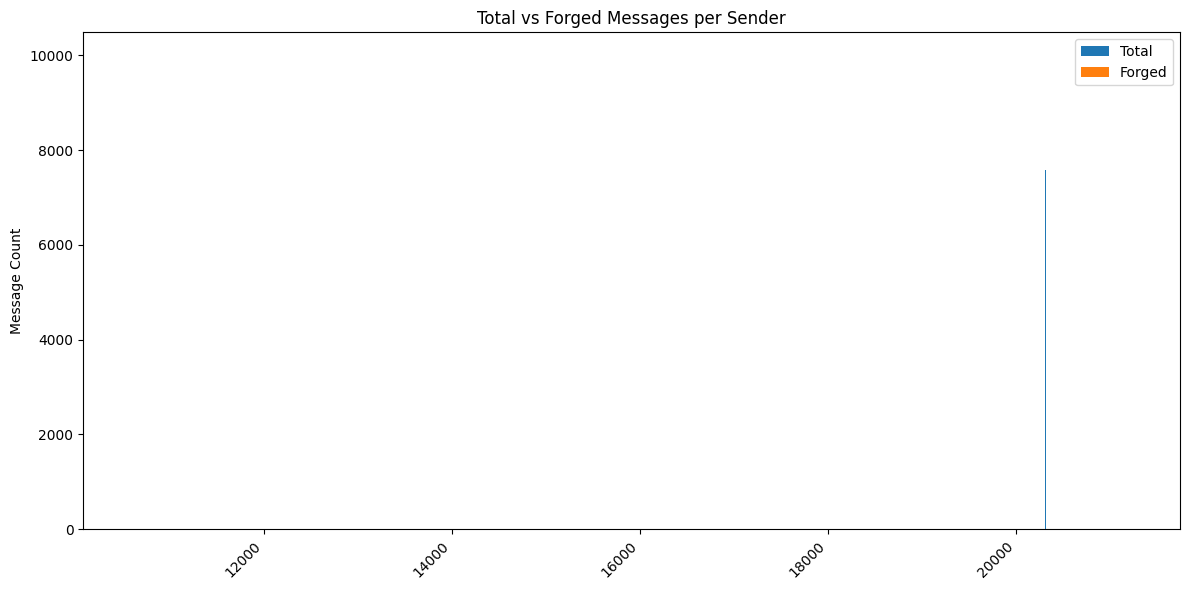

In [17]:
top = sender_stats.sort_values(
    "total_messages", ascending=False
).head(20)

plt.figure(figsize=(12,6))
plt.bar(top["sender_log"], top["total_messages"], label="Total")
plt.bar(top["sender_log"], top["forged_messages"], label="Forged")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Message Count")
plt.title("Total vs Forged Messages per Sender")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
merged['is_forged'].describe()

count     2142064
unique          1
top         False
freq      2142064
Name: is_forged, dtype: object

In [22]:
sender_stats.describe(include="all")

,sender_log,total_messages,forged_messages,pos_mismatches,spd_mismatches,acl_mismatches,forged_ratio
count,1964.000000,1964.000000,1964.0,1964.0,1964.0,1964.0,1964.0
mean,16289.831976,1090.663951,0.0,0.0,0.0,0.0,0.0
std,3403.252157,1416.831200,0.0,0.0,0.0,0.0,0.0
min,10317.000000,1.000000,0.0,0.0,0.0,0.0,0.0
25%,13345.500000,322.500000,0.0,0.0,0.0,0.0,0.0
50%,16290.000000,645.500000,0.0,0.0,0.0,0.0,0.0
75%,19234.500000,1156.000000,0.0,0.0,0.0,0.0,0.0
max,22209.000000,9983.000000,0.0,0.0,0.0,0.0,0.0
